# Quantum Phase Estimation

In [28]:
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile 
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from scipy.linalg import expm
pi = np.pi

## Table of Contents

* [Overview](#Overview)
* [Algorithm](#Algorithm)
    * [Final State Proof](#Final-State-Proof)
    * [Examples](#Examples)
      * [Single Qubit QPE](#Single-Qubit-QPE)
      * [Multi-Qubit QPE](#Multi-Qubit-QPE)
* [Error Analysis](#Error-Analysis)

## Overview

The Quantum Phase Estimation (QPE) algorithm is one of the most fundamental procedures in quantum computing. Similar to the Hadamard test, it estimates the phase $\varphi$ in an eigenvalue of a unitary operator $U$, i.e., when
$$U |\psi \rangle = e^{2\pi i \varphi} |\psi\rangle$$
where $|\psi\rangle$ is a known eigenstate.

QPE generalizes the Hadamard test by using a register of ancilla qubits to extract multiple bits of $\varphi$, thereby increasing the resolution of the estimate. It forms the foundation of many quantum algorithms, including those for factoring, linear systems, and Hamiltonian simulation
        
To encode $\varphi$ onto multiple qubits, controlled $U$ gates are applied multiple times to each single qubit to isolate a specific binary digit of $\varphi$. These rotations done in succession will encode $\varphi$ into the Fourier basis, then using the IQFT, the state vector will be transformed into the computational basis for measurement.

## Algorithm

Let $U \in \mathbb{C}^{n\times n}$ be unitary. The quantum phase estimation algorithm is defined via the circuit below.

<center><img src='Images\5-QPE_Circuit-1.png'></center>

<center><i>Quantum phase estimation circuit where $H$ is the Hadamard gate, $U \in \mathbb{C}^{n \times n}$ is unitary and $QFT^{\dagger}$ is the inverse QFT. The top qubits are the ancilla qubits and the bottom qubits represent the state $|\psi\rangle$.</i></center>

### Final State Proof

The initial state of the circuit shown above can be represented as
$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle.$$
A Hadamard gate is then applied to all $n$ ancilla qubits generating a uniform superposition, i.e.,

$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle = |+\rangle^{\otimes n}|\psi\rangle.$$

Next, the controlled $U$ gates are applied. Since $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, this yields

$$U^{2^j}|\psi\rangle = (e^{2\pi i \varphi})^{2^j}|\psi\rangle = e^{2\pi i 2^j \varphi}|\psi\rangle.$$

Therefore, by controlling this gate and applying it to all $n$ qubits, it only affects the state for the case where it is $|1\rangle$. Applying the controlled $U^{2^j}$, with $0 \leq j \leq n-1$, yields

$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle,$$

where $k$ is the integer representation of an $n$-bit binary number. The IQFT is then applied resulting in the state

$$\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle \xrightarrow{\text{QFT}_N^\dagger} \frac{1}{2^n}\sum_{x=0}^{2^n-1}\sum_{k=0}^{2^n-1}e^{2\pi i k(\varphi - \frac{x}{2^n})}|x\rangle|\psi\rangle = |\psi_3\rangle.$$

As a reminder, when $n=1$, $\text{QFT}_n = H$, so QPE with one ancilla qubit is the same circuit as the real HT.

### Examples

Methods used for these examples:

In [3]:
def plot_distribution(ax, angle, ancilla_bits, counts):
    ax.tick_params(axis = 'x', rotation=90)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Binary String")
    ax.set_title(f"\u03C6= {angle:0.5f}")
    bin_nums = []
    shots  = 0
    for i in counts.values(): shots+=i
    for i in range(2**ancilla_bits):
        bin_nums.append(bin(int(i))[2:])
        bin_nums[i]=bin_nums[i].zfill(ancilla_bits)
    updated_counts = []
    big_prob = []
    big_prob_str = []
    for i in bin_nums:
        try:
            num = counts[i]
        except:
            num = 0
        finally:
            prob = num/shots
            updated_counts.append(prob)
            if prob >0.1:
                big_prob.append(prob)
                big_prob_str.append(i)
    bar = ax.bar(bin_nums, updated_counts)
    bar = ax.bar(big_prob_str, big_prob, width=0)
    ax.bar_label(bar, fmt=lambda x: f" {x:0.2f}", fontsize= 10, rotation=90)
    ax.set_ylim(ymax = max(updated_counts)+.11)

#### Single Qubit QPE

To test QPE, $4$ ancilla qubits with $10^3$ shots is used on a fault-tolerant Qiskit AerSimulator, estimating the phase angles $\varphi = 1/4$ and $\varphi = 2/3$ for the unitary matrix
$$U = \begin{bmatrix} 1 & 0 \\ 0 & e^{i2\pi \varphi} \end{bmatrix}.$$


In [15]:
num_of_shots = 10**4
ancilla_bits = 4
angle = 2/3

In [16]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.6666666666666666
Binary Representation of the phase angle:  0.1010


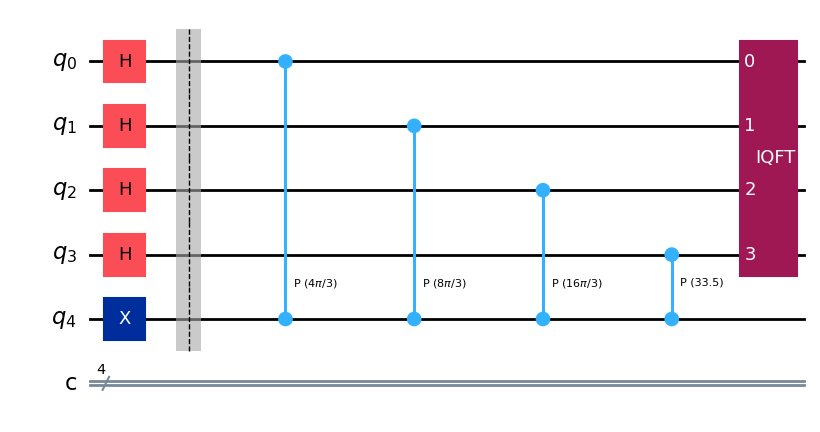

In [17]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
for i in range(ancilla_bits):
    qc.h(i)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)
qc.append(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

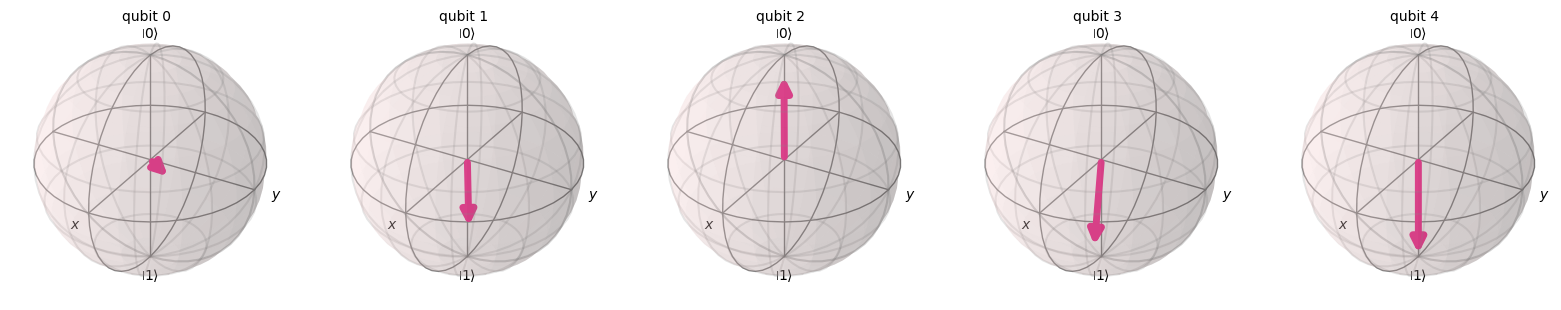

In [18]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

After a sampling, the probability of measuring each specific state is calculated by dividing the number of times each state was counted by the total number of shots.

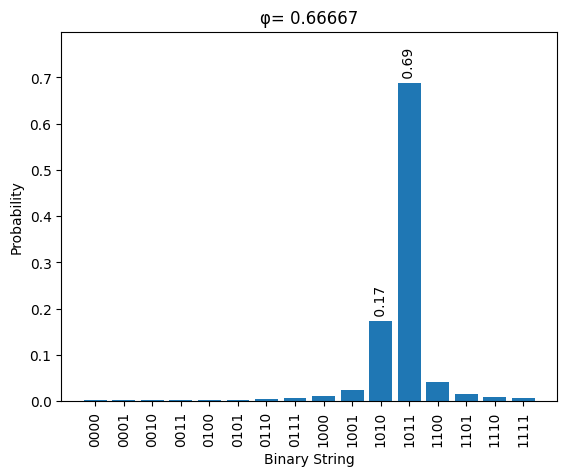

In [19]:
for i in range(ancilla_bits): qc.measure(i,i)

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = num_of_shots).result().get_counts()

fig,ax = plt.subplots(nrows = 1, ncols = 1)
plot_distribution(ax, angle, ancilla_bits, counts)
plt.show()

In [20]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.1011
Decimal Number with Equivalent Value: 0.6875


Notice that since the phase angle $\varphi = \frac{1}{4}$ can be exactly represented with $2$ binary digits, using at least $2$ ancilla qubits in QPE returns the phase angle deterministically.

Contrarily, a phase angle $\varphi = \frac{2}{3}$ cannot be exactly represented with any number of binary digits therefore the outcome is probabilistic.

#### Multi-Qubit QPE

Interestingly, the input state changes. Suppose we define

\begin{equation}
    U = \begin{pmatrix}e^{2\pi.25}&0&0&0\\0&e^{2\pi.3}&0&0\\0&0&e^{2\pi.4}&0\\0&0&0&e^{2\pi.5}\end{pmatrix}.
\end{equation}


In this case the input state changes the output of QPE.

In [46]:
ancilla_bits = 5
input_state = '01'

In [47]:
eigen_bits = 2
H = np.asarray([[.25,0,0,0],
                [0,.3,0,0],
                [0,0,.4,0],
                [0,0,0,.5]], complex)

print("Hamiltonian:\n", H)

print("\nEigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)

# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

Hamiltonian:
 [[0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.3 +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.4 +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.5 +0.j]]

Eigenvalues of the Hamiltonian:
 [0.25+0.j 0.3 +0.j 0.4 +0.j 0.5 +0.j]

Lowest energy Eigenvalue (0.25+0j)


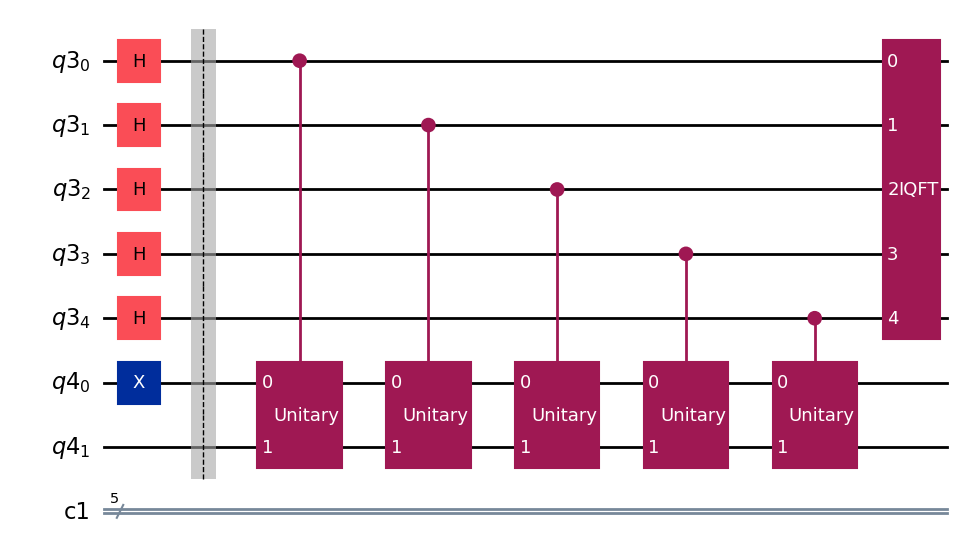

In [48]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

# the input state gets moddified here
if input_state[1] == '1':
    qc.x(qr_eigenstate[0])
if input_state[0] == '1':
    qc.x(qr_eigenstate[1])


qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
qc.draw('mpl')

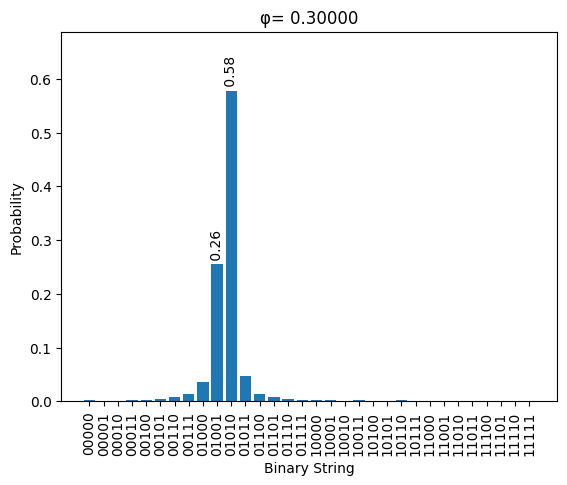

In [49]:
qc.measure(qr_ancilla, cr)

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10**4).result().get_counts()
fig,ax = plt.subplots(nrows = 1, ncols = 1)
if input_state == '00': angle = .25
if input_state == '01': angle = .3 
if input_state == '10': angle = .4 
if input_state == '11': angle = .5 
plot_distribution(ax, angle, ancilla_bits, counts)
plt.show()

In [50]:
max_num = 0
binary_num = ''
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))
if input_state == '00': angle = .25
if input_state == '01': angle = .3 
if input_state == '10': angle = .4 
if input_state == '11': angle = .5 
print("Actual Eigenvalue", angle)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Actual Eigenvalue 0.3
Binary Number Output: 0.01010
Decimal Number with Equivalent Value: 0.3125


## Error Analysis

QPE yields a distribution over estimates centered around the true phase. However, when the targeted phase has no exact binary bit expansion, QPE returns the nearest binary approximation with high probability. Quantifying this error is the subject of this section.

Throughout this section, we make the assumption that 

$$U|\psi_j \rangle = e^{i2\pi \varphi_j}|\psi_j\rangle,$$

where $0\leq \varphi_0 \leq \varphi_1 \dots \leq \varphi_{N-1}\leq 1$, and the goal is to use QPE to find the phase of the ground state $\varphi_0$. We assume $\varphi_0$ does not have an exact $d$-bit representation and we apply QPE to the initial state $|0^t\rangle|\psi_0\rangle$ where $t>d$. 

### Proof

Performing QPE on the initial state $|0\rangle^{\otimes t}|\psi_0\rangle$ gives  
$$|0\rangle^{\otimes t}|\psi_0\rangle \xrightarrow{H^{\otimes t}\otimes I} \frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle|\psi_0\rangle$$
$$\xrightarrow{U}\frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle e^{i2\pi j\varphi_0}|\psi_0\rangle $$
$$\xrightarrow{\text{QFT}^{\dagger}} \sum_{k'\in[2^t]}\left(\frac{1}{2^t}\sum_{j\in [2^t] }e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}\right)|k'\rangle|\psi_0\rangle $$
For simplicity, it can be said that 
$$|0\rangle^{\otimes t}|\psi_0\rangle \xrightarrow{\text{QPE}} \sum_{k'}\gamma_{0,k'}|k'\rangle|\psi_0\rangle, \quad \text{with} 
\quad \gamma_{0,k'} = \frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}.$$

Here, we visualize $|\gamma_{0,k'}|$ by plotting it against the phase $\varphi_{0,k'}$ with $t = 6$ and $t = 10$ ancilla qubits for a phase of $\varphi_0 = 0.35$. Since this decimal does not have an exact bit binary representation, the vector is "between" different standard basis vectors and the eigenvector is represented as a linear combination of standard basis vectors. The QPE distribution $|\gamma_{0,k'}|$ becomes increasingly peaked around the closest binary approximation to $\varphi_0$ as shown below. As $t\to \infty$, this distribution converges to a Dirac delta. In fact, for the case where $\varphi_0$ has an exact $d$-bit representation (meaning that $\varphi_0 = \tilde{\varphi}_{k_0'}$ for some $k_0'$), then $\gamma_{0,k'} = \delta_{k',k_0'}$ (the Dirac delta function).

First, we set the phase to be estimated by the algorithm and convert it into its $t$-bit binary representation where $t$ is the number of ancilla qubits. The quantum circuit is then initizalized with $t+1$ qubits and an $H$ gate is applied to all $t$ ancillas. The last qubit represents the quantum state $|\psi\rangle$ which is prepared with an $X$ gate. A for loop then applies all the controlled $U$ operations targeted to the state $|\psi\rangle$ and controlled by each ancilla bit. Finally, the $\text{QFT}^{\dagger}$ function defined above is applied to the circuit, and every ancilla bit is measured. 

With the QPE circuit created we run it on the Qiskit AerSimualtor to return the counts of each $t$-bit binary number. Then by looping through the binary numbers and converting them to base $10$ decimals, we can create an array of all of the possible values this circuit can return. 

In [42]:
def print_phase_angle(phase_angle):
    print("Decimal Representation of the phase angle:", phase_angle)
     # convert phase to binary for respective number of ancilla qubits
    reading_angle = phase_angle
    print("Binary Representation of the phase angle:  0.", end="")
    for i in range(1,ancilla_bits+1):
        if reading_angle - 1/2**i >= 0:
            reading_angle -= 1/2**i
            print("1", end="")
        else:
            print("0", end="")
    print('\n')
def create_example_plot(ancilla_bits, phase_angle, domain_variance):
    qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
    for i in range(ancilla_bits):
        qc.h(i)
    qc.x(ancilla_bits)
    qc.barrier()
    # apply controlled unitaries
    for i in range(ancilla_bits): 
        qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)
    qc.append(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
    #print(qc)
    for i in range(ancilla_bits): qc.measure(i,i)
        
    backend = AerSimulator()
    trans_qc = transpile(qc, backend, optimization_level=3)
    sampler = Sampler(backend)
    job = sampler.run([trans_qc], shots = num_of_shots)
    result = job.result()
    data = result[0].data
    counts = data[list(data.keys())[0]].get_counts()
    
    kvals = []
    binaries = []
    for key in counts:
        binaries.append(key)
    
    # convert all binary numbers to decimals and make array
    for num in binaries:
        decimal = 0
        for i in range(len(num)):
            decimal += int(num[i])/2**(i+1)
        kvals.append(decimal)
    kvals = np.sort(np.array(kvals))
    gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
    gamma = gamma/(np.sqrt(sum(gamma**2)))

    # filter data for graphing
    peak = int(np.argmax(gamma))
    new_kvals = []
    for k in kvals:
        if k<kvals[peak]+domain_variance and k>kvals[peak]-domain_variance:
            new_kvals.append(k)
    new_gamma = []
    for i in range(len(new_kvals)):
        index = np.where(kvals == new_kvals[i])[0][0]
        new_gamma.append(gamma[index])
    plt.plot(new_kvals, new_gamma, 'r*')
    plt.plot(new_kvals, new_gamma, 'k-')
    plt.xlabel("$\u03c6\u0303_{0,k'}$")
    plt.ylabel('$|\u03B3_{0,k}|$')
    plt.title("$|\u03B3_{0,k}|$ vs $\u03c6\u0303_{0,k'}$ for t = "+str(ancilla_bits)+" ancilla qubits and $\u03c6_0 = $"+str(phase_angle))
    plt.show()

Decimal Representation of the phase angle: 0.35
Binary Representation of the phase angle:  0.0101



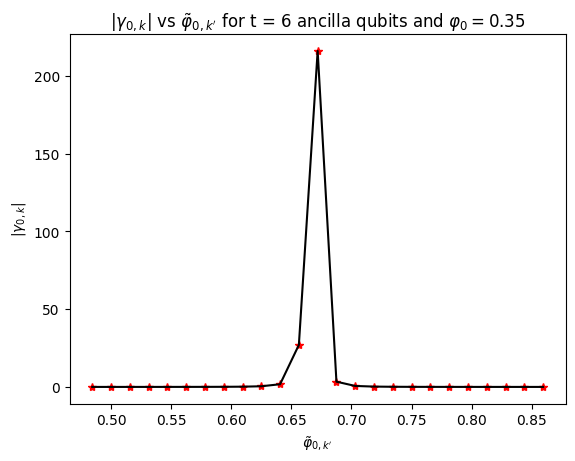

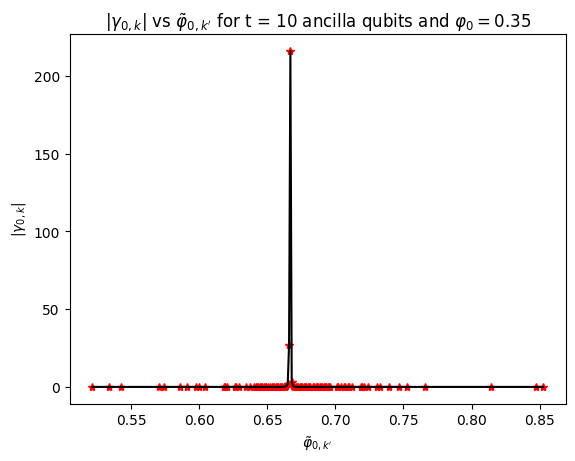

In [43]:
print_phase_angle(.35)
create_example_plot(6, .35, .2) # t = 6
create_example_plot(10, .35, .2) # t = 10

Inspecting the output of the QPE circuit, we see that it peaks at $x = 2^n\varphi$, which is the input state.

Recognizing that $\gamma_{0,k'}$ is a geometric series with the common ratio $r = e^{i2\pi \left(\varphi_0 - \frac{k'}{2^t}\right)}$ and the coefficient $a = \frac{1}{2^t}$, we find that
$$\gamma_{0,k'} = \frac{1}{2^t}\frac{1-r^{2^t}}{1-r} = \frac{1}{2^t}\frac{1-e^{i\pi 2^{t+1} \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}{1-e^{i2\pi \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}, \quad \text{with} \quad \tilde{\varphi}_{k'} = \frac{k'}{2^t},$$
where we used that
$$a + ar^2 + ar^3 + \dots + ar^n = \frac{a(r^n-1)}{r-1}.$$
Since $e^{i2\pi x}$ is a $1$-periodic function, $x \mod{1}$ is the only measurable value.  Therefore, when estimating the phase $k_0'$, we seek the precision $\epsilon = \frac{1}{2^d} = \frac{2^{t-d}}{2^t}$ such that
$$\left|\varphi_0-\tilde{\varphi}_{k_0'}\right|_1<\epsilon.$$
Since for any $\theta \in [-\pi,\pi]$
$$\left|1-e^{i\theta}\right| = \sqrt{(1-\cos\theta)^2 + \sin^2\theta} = \sqrt{2(1-\cos\theta)} = 2\left|\sin\frac{\theta}{2}\right|\geq\frac{2}{\pi}\left|\theta\right|,$$
and
$$\left|1 - e^{i\theta}\right| \leq \left|1\right| + \left|e^{i\theta}\right| = \sqrt{1^2} + \sqrt{\cos^2\theta - (i\sin\theta)^2} = 1 + \sqrt{\cos^2\theta + \sin^2\theta} = 1 + 1 = 2,$$
we find
$$\left|\gamma_{0,k'}\right| \leq \frac{2}{2^t2\pi\frac{2}{\pi}\left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1} = \frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}.$$

The binary measurement outcome $k_0'$ can be viewed as a random variable where the probability of obtaining $\tilde{\varphi}_{k_0'}$ at least a distance $\epsilon$ away from the expected value $\varphi_0$ is
$$\mathbb{P}\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) = \sum_{\left|\varphi_0 - \tilde{\varphi}_{k'}\right|\geq\epsilon}\left|\gamma_{0,k'}\right|^2 \leq \left(\frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}\right)^2 =  \frac{1}{4T^2\left|\varphi_0 -\tilde{\varphi}_{k'}\right|^2_1},$$
where $T = 2^t$. In other words, this expression represents the probability that the estimated phase is not within the desired error. 

Setting $x = \left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1$ this yields 
$$\mathbb{P}\left(\left|x\right|\geq\epsilon\right) = \sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} =: \sum_{|x|\geq\epsilon} f(x).$$

For example, since the accuracy goal is $\epsilon = 2^{-d}$, when $d=5$, $f(x)$ can be visualized with $\epsilon = 0.03125$.

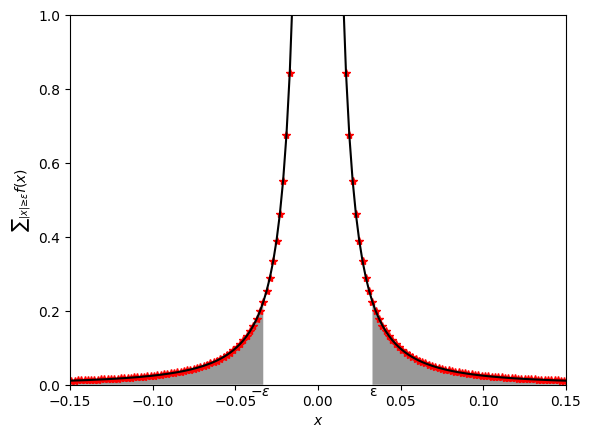

In [44]:
def sum(x):
    sum = 1/(4*(T**2)*(x**2))
    return sum

d = 5
T = 2**d
eps = 1/(2**d)

x = np.linspace(-1,1,1000)
dx1 = x[x >= eps]
dx2 = x[x <= -eps]

func = sum(x)

plt.plot(x, func, 'r*')
plt.plot(x, func, 'k-')

plt.fill_between(dx1, sum(dx1), facecolor='k', alpha=0.4)
plt.fill_between(dx2, sum(dx2), facecolor='k', alpha=0.4)

plt.text(eps,-0.03,'ε')
plt.text(-eps-0.01,-0.03,'$-ε$')

plt.xlabel('$x$')
plt.ylabel('$∑_{|x|≥ ε} f(x)$')
plt.title('')

plt.ylim(0, 1)
plt.xlim(-0.15, 0.15)
plt.show()

Since $f$ is a symmetric function, 
$$\sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} = \sum_{x\geq\epsilon}\frac{2}{4T^2x^2} = \sum_{x\geq\epsilon}\frac{1}{2T^2x^2}.$$
As exemplified above, we see the sum is upper bounded by the integral from $\epsilon$ onwards. Noting that 
$$\sum_{x\geq\epsilon}\frac{1}{x^2} \leq \int_\epsilon^\infty \frac{1}{x^2}dx = \frac{1}{\epsilon},$$
the expression can be bounded, i.e., $T\geq1$ yields
$$\sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} \leq \frac{1}{2T^2}\frac{1}{\epsilon} \leq \frac{1}{2T\epsilon}.$$
Since $T\epsilon = 2^{t-d}$, we set $t-d = \log_2{(\delta^{-1})}$ so that $T\epsilon = \delta ^{-1}$. For $0<\delta<1$, we then find that the failure probability is
$$\mathbb{P}\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) \leq \frac{1}{2T\epsilon} = \frac{\delta}{2} \leq \delta.$$

Therefore, in order to obtain the phase $\varphi_0$ to an accuracy of $\epsilon = 2^{-d}$ with a success probability of at least $1-\delta$, a total of $t = d + \log_2{(\delta^{-1})}$ ancilla qubits are necessary to store the phase value. Furthermore, since $T\epsilon = \delta^{-1}$, the simulation run time must be $T = (\epsilon\delta)^{-1}$.